# Categorizing user complaints of the four largest telecommunications companies in South Africa using Topic Modelling

> ℹ️ Source Code

The recommended approach to running the code is to clone the git repository from https://github.com/JohnnyFoulds/dsm020-2021-oct and open it in Visual Studio Code as a [Development Container](https://code.visualstudio.com/docs/remote/create-dev-container). This will create an environment identical to what has been used during development. This notebook is located at `/workspaces/dsm020-2021-oct/coursework_02/cw.ipynb` in the development container.

The following packages were added explicitly to the development container and will be required to execute the notebook if it is to be executed outside of VS Code.

[requirements.txt](https://github.com/JohnnyFoulds/dsm020-2021-oct/blob/master/requirements.txt)

```
ipykernel==6.4.1
ipywidgets==7.6.3
nltk==3.6.5
matplotlib==3.4.3
pandas==1.3.4
openpyxl==3.0.9
pyquery==1.4.3
requests==2.26.0
scikit-learn==0.23.2
plotly==5.4.0
pycaret==2.3.6
shap==0.40.0
pyarrow==6.0.1
bs4==0.0.1
fasttext==0.9.2
kaleido==0.2.1
```

In [43]:
## import libraries
import pandas as pd
import math
from urllib.error import HTTPError, URLError
import random
import gensim
import plotly
import json
import kaleido
from wordcloud import WordCloud
from pycaret.nlp import *
from IPython.utils import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

> ❗ Please be sure to execute the following lines since `pycaret.nlp` requires english language model. A kernel restart is required after the models have been downloaded.

In [44]:
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

Defaulting to user installation because normal site-packages is not writeable
  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /home/vscode/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/vscode/nltk_data...
[nltk_data]   Package conll2000 is already up-

## Appendix A: Web References

The folling is a list of technical resources that were consulted.

### Topic Modelling

- [Matti Lyra - Evaluating Topic Models](https://www.youtube.com/watch?v=UkmIljRIG_M)
- [Bhargav Srinivasa Desikan - Topic Modelling (and more) with NLP framework Gensim](https://www.youtube.com/watch?v=ZkAFJwi-G98)
- [Gensim - Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html)

### Pycaret

- [Topic Modeling on PyCaret](https://towardsdatascience.com/topic-modeling-on-pycaret-2ce0c65ba3ff)
- [Natural Language Processing Tutorial (NLP101) - Level Beginner](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Beginner%20-%20NLP101.ipynb)
- [Natural Language Processing Tutorial (NLP102) - Level Intermediate](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Intermediate%20-%20NLP102.ipynb)
- [Five common misunderstandings of pycaret](https://developpaper.com/five-common-misunderstandings-of-pycaret/)

### Plots

- [seaborn - Example gallery](https://seaborn.pydata.org/examples/index.html)
- [Creating multiple subplots using plt.subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

### Dataset

- [How to balance a dataset in Python](https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704)

### Other

- [Capturing Output With %%capture](https://notebook.community/lifeinoppo/littlefishlet-scode/RES/REF/python_sourcecode/ipython-master/examples/IPython%20Kernel/Capturing%20Output)
- [Side by side Wordclouds in matplotlib](https://stackoverflow.com/questions/34165130/side-by-side-wordclouds-in-matplotlib)

## III. Experimental Setup

In [45]:
random_seed = 2480

### A. Data Collection and Per-Processing


The Hellopeter telecommunications dataset prepared in coursework 1 is loaded from the GitHub repository.

In [46]:
# load the raw datasets retrieved fom hellopeter
try:
    telecom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/output/telecommunications.gzip')
    telecom_reviews.info()
except HTTPError as err:
    if err.code == 4041:
        print('The file was not found on GitHub (404): %s' % err.filename)
    else:
        print('The file could not be retrieved from GitHub, please review the original error message: %s' % err.msg)
except URLError as err:
    print('There is a problem with the source URL: %s' % err.reason)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35072 entries, 0 to 35071
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35072 non-null  object        
 1   created_at                  35072 non-null  datetime64[ns]
 2   author                      35072 non-null  object        
 3   author_id                   35072 non-null  object        
 4   review_title                35072 non-null  object        
 5   review_rating               35072 non-null  int64         
 6   review_content              35072 non-null  object        
 7   business_slug               35072 non-null  object        
 8   permalink                   35072 non-null  object        
 9   replied                     35072 non-null  bool          
 10  messages                    35072 non-null  object        
 11  industry_slug               35072 non-null  object    

#### 1) Discard the subsample of 4-5 reviews as these are considered compliments

[Text(0.5, 1.0, 'Review Star Ratings'),
 Text(0.5, 0, 'Star Rating'),
 Text(0, 0.5, 'Count')]

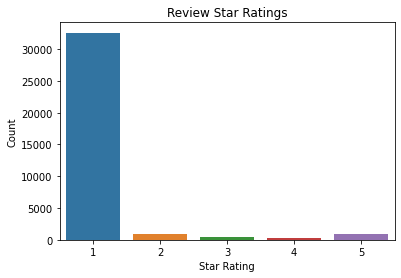

In [47]:
sns.countplot(
    data=telecom_reviews,
    x='review_rating').set(
    title='Review Star Ratings',
    xlabel='Star Rating',
    ylabel='Count')

In [48]:
def show_remaining_count(original, filtered):
    """
    Show information of data data rows remaining after filtering have been applied to the original dataset.

    Parameters
    ----------
    original : pandas.DataFrame
        The unfiltered dataset.
    filtered : pandas.DataFrame
        The filtered dataset.
    """
    count_original = original.shape[0]
    count_filtered = filtered.shape[0]

    print('(%d) reviews remaining out of (%d) -- %.2f' % (
        count_filtered,
        count_original,
        count_filtered / count_original
        ))

In [49]:
# remove the positive ratings
df_complaints = telecom_reviews[telecom_reviews.review_rating < 4].copy()

# display the records remaining
show_remaining_count(telecom_reviews, df_complaints)

(33935) reviews remaining out of (35072) -- 0.97


#### 2) Removing special characters from the text

In [50]:
def remove_special_characters(text_series:pd.Series) -> pd.Series:
    """
    Remove special characters from a text series.

    Parameters
    ----------
    text_series : pandas.Series
        The text series to clean.

    Returns
    -------
    pandas.Series
        The cleaned text series.
    """
    text_series = text_series.str.replace(r'[\n\xa0]+', ' ', regex=True)
    text_series = text_series.str.replace(r'^\s+', '', regex=True)  
    text_series = text_series.str.replace(r'$\s+', '', regex=True)  
    text_series = text_series.str.replace(r'\s+', ' ', regex=True)    

    return text_series

df_complaints['review_content_clean'] = remove_special_characters(df_complaints['review_content'])

#### 3) Create a balanced data set 

Create a balanced data set using [imbalanced-learn](https://imbalanced-learn.org/) by undersampling reviews from each telecommunications company to the size of the company with the least number of reviews.

[Text(0.5, 1.0, 'Reviews per Company'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Count')]

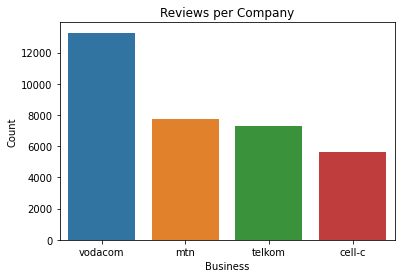

In [51]:
sns.countplot(
    data=df_complaints,
    x='business_slug').set(
    title='Reviews per Company',
    xlabel='Business',
    ylabel='Count')

In [52]:
# perform the under sampling
under_sampler = RandomUnderSampler(random_state=random_seed)
df_complaints_balance, _ = under_sampler.fit_resample(df_complaints, df_complaints.business_slug)

# display the records remaining
show_remaining_count(df_complaints, df_complaints_balance)

(22568) reviews remaining out of (33935) -- 0.67


[Text(0.5, 1.0, 'Reviews after filtering'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Count')]

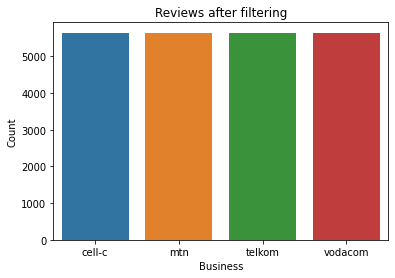

In [53]:
sns.countplot(
    data=df_complaints_balance,
    x='business_slug').set(
    title='Reviews after filtering',
    xlabel='Business',
    ylabel='Count')

The pycaret nlp setup found in `/usr/local/lib/python3.8/site-packages/pycaret/nlp.py` performs the following actions and thus does not have to performed as pre-processing steps outside of the library.

1. Removing numeric characters from the text.
2. Removing special characters.
3. Word Tokenization
4. Remove the English stopwords as defined in the NLTK library.
5. Bigram Extraction.
6. Trigram Extraction.
7. Perform Lemmatization using the spaCy library. The following parts of speech are retained: `["NOUN", "ADJ", "VERB", "ADV"]`
8. Remove custom stopwords.


### B. Topic Modeling Training and Evaluation

In [54]:
class TopicModeling():
    """
    Class to perform topic modeling on the reviews.
    """
    def __init__(self, data:pd.DataFrame, random_seed:int=None):
        """
        Initialize the class.

        Parameters
        ----------
        data : pandas.DataFrame
            The dataframe containing the reviews.
        random_seed : int
            The random seed to use.
        """
        # set the data
        assert isinstance(data, pd.DataFrame), 'data must be a pandas.DataFrame'
        self.data = data
        self.data.reset_index(inplace=True, drop=True)
        self.assigned_data = None

        # set the random seed
        if random_seed is None:
            self.random_seed = random.randint(150, 9000)
        else:
            self.random_seed = random_seed

    def setup(self, target:str=None, custom_stopwords:list=None, verbose:bool=True) -> dict:
        """
        Perform the pre-prossesing steps with the aid of the PyCaret library.
        
        The following actions are performed:
            1. Removing numeric characters from the text.
            2. Removing special characters.
            3. Word Tokenization
            4. Remove the English stopwords as defined in the NLTK library.
            5. Bigram Extraction.
            6. Trigram Extraction.
            7. Perform Lemmatization using the spaCy library. The following parts of speech are retained: `["NOUN", "ADJ", "VERB", "ADV"]`
            8. Remove custom stopwords        

        Parameters
        ----------
        target : str
            The target variable.
        custom_stopwords : list
            A list of custom stopwords to use.
        verbose : bool
            Whether to display the pre-processing steps.

        Returns
        -------
        result : dict
            Return a dictionary containing the text, corpus, and id2word data.
        """
        result = {}

        # set the target variable
        self.target = target

        # set the custom stopwords
        if custom_stopwords is not None:
            self.custom_stopwords = custom_stopwords
        else:
            self.custom_stopwords = []

        # set the verbose flag
        self.verbose = verbose

        # pre-process the data
        result['text'], _, result['corpus'], result['id2word'], *_ = setup(
            data=self.data, 
            target=target, 
            verbose=verbose, 
            session_id=self.random_seed)

        self.text = result['text']
        self.corpus = result['corpus']
        self.id2word = result['id2word']
        
        # reset the assigned data
        self.assigned_data = None

        return result

    def create_model(self, model:str='lda', num_topics:int=4, verbose:bool=False):
        """
        Train the given topic model specified by the 'model' parameter.

        Parameters
        ----------
        model : str, default 'lda'
            Models available (ID - Name):

            * 'lda' - Latent Dirichlet Allocation         
            * 'lsi' - Latent Semantic Indexing           
            * 'hdp' - Hierarchical Dirichlet Process
            * 'rp' - Random Projections
            * 'nmf' - Non-Negative Matrix Factorization

        num_topics : int, default 4
            The number of topics to use.
        verbose : bool, default False
            When set to True, status updates are displayed.

        Returns
        -------
        Trained Model
        """
        # check for allowed models
        assert model in ['lda', 'lsi', 'hdp', 'rp', 'nmf'], 'model must be one of the following: lda, lsi, hdp, rp, nmf'

        # create the model
        self.trained_model = create_model(
            model=model, 
            num_topics=num_topics, 
            verbose=verbose, 
            multi_core=True)

        # reset the assigned data
        self.assigned_data = None

        return self.trained_model

    def create_tuned_model(self, model:str='lda', fold:int=10, verbose:bool=True):
        """
        Train the given topic model specified by the 'model' parameter.

        Parameters
        ----------
        model : str, default 'lda'
            Available models (ID - Model):

            * 'lda' - Latent Dirichlet Allocation         
            * 'lsi' - Latent Semantic Indexing           
            * 'hdp' - Hierarchical Dirichlet Process
            * 'rp' - Random Projections
            * 'nmf' - Non-Negative Matrix Factorization

        fold : int, default 10
            The number of folds to use. Must be at least 2. 
        verbose : bool, default True
            When set to True, status updates are displayed.

        Returns
        -------
        Trained Model with optimized ``num_topics`` parameter.
        """
        # check for allowed models
        assert model in ['lda', 'lsi', 'hdp', 'rp', 'nmf'], 'model must be one of the following: lda, lsi, hdp, rp, nmf'

        # create the tuned model
        self.trained_model = tune_model(
            model=model, 
            fold=fold, 
            verbose=verbose, 
            multi_core=True)

        # reset the assigned data
        self.assigned_data = None

        return self.trained_model

    def assign_model(self, verbose:bool=False) -> pd.DataFrame:
        """
        Assigns topic labels to the dataset using the trained_model.

        Parameters
        ----------
        verbose : bool, default False
            When set to True, status updates are displayed.

        Returns
        -------
        pandas.DataFrame containing the topic labels.
        """
        # assign the topic labels
        df_assigned = assign_model(self.trained_model, verbose=verbose)
        self.assigned_data = self.data.join(df_assigned.iloc[:,-(2+self.trained_model.num_topics):])
        
        # join the cleaned topic text
        self.assigned_data = self.assigned_data.join(
            pd.DataFrame([" ".join(item) for item in self.text], columns=['Topic_text'])
        )

        return self.assigned_data

    def extract_topic_coherence_data(self, num_words:int=10, num_sample:int=3, verbose:bool=False) -> list:
        """
        Extracts topic coherence data from the assigned data for manual review.

        Parameters
        ----------
        num_words : int, default 10
            The number of words to use for each topic.

        num_sample : int, default 3
            The number of samples itemf from the target to include for each topic.

        verbose : bool, default False
            When set to True, status updates are displayed.

        Returns
        -------
        list containing the topic coherence data.
        """
        assert self.trained_model is not None, 'The model must be trained before coherence data can be extracted.'

        output = []

        # get the assigned data
        if self.assigned_data is None:
            self.assigned_data = self.assign_model(verbose=verbose)

        for topic_num, word_data in self.trained_model.show_topics(formatted=False, num_words=10):
            topic = {'topic_num': topic_num}
            output.append(topic)
            
            # get the most siginficant words for the topic
            topic['word_list'] = " ".join([word for word, _ in word_data])

            # get the list of sample items for the topic
            filtered_df = self.assigned_data.loc[self.assigned_data["Dominant_Topic"] == 'Topic %d' % topic_num]
            topic['samle_list'] = filtered_df.sort_values(by='Perc_Dominant_Topic', ascending=False).head(num_sample)[self.target].tolist()
                  
        return output


    def show_topic_coherence_data(self, num_words:int=10, num_sample:int=3, verbose:bool=False):
        """
        Displays the topic coherence data.

        Parameters
        ----------
        num_words : int, default 10
            The number of words to use for each topic.

        num_sample : int, default 3
            The number of samples itemf from the target to include for each topic.

        verbose : bool, default False
            When set to True, status updates are displayed.
        """
        output = []

        # extract the topic coherence data
        topic_coherence_data = self.extract_topic_coherence_data(num_words=num_words, num_sample=num_sample, verbose=verbose)
    
        # format the table header
        str_header = '| Topic | Words |'
        str_divider = '|-------|------|'
        for i in range(num_sample):
            str_header += ' Sample %d |' % (i+1)
            str_divider += '-------|'
        output.append(str_header)
        output.append(str_divider)

        # format each topic
        for topic in topic_coherence_data:
            str_row = '| Topic %d | %s |' % (topic['topic_num'], topic['word_list'])
            for sample in topic['samle_list']:
                str_row += ' %s |' % sample
            output.append(str_row)


        # display the output as markdown
        print('\n'.join(output))

    def plot_topic_distribution(self, interactive:bool=True):
        """
        Plot the Topic Infer Distribution.

        Parameters
        ----------
        interactive : bool, default True
            When set to True, the plot is displayed in an interactive window.
        """
        assert self.trained_model is not None, 'The model must be trained before plotting the topic distribution.'

        if interactive:
            plot_model(self.trained_model, plot='topic_distribution')
        else:
            with io.capture_output() as captured_plot:
                plot_model(self.trained_model, plot='topic_distribution')
    
            json_plotly = json.dumps(list(captured_plot.outputs[1].data.items())[0][1])
            figure_plotly = plotly.io.from_json(json_plotly)
            figure_plotly.show(renderer="png")

    def plot_wordcloud(self, topic_num:int, plot:bool=True) -> WordCloud:
        """
        Plot the Topic Wordcloud.

        Parameters
        ----------
        topic_num : int
            The topic number to plot.

        plot : bool, default True
            When set to True, the plot is rendered.

        Returns
        -------
        wordcloud : WordCloud
            The wordcloud object that can be used to generate the plot.
        """
        assert self.trained_model is not None, 'The model must be trained before plotting the topic wordcloud.'
        assert topic_num < self.trained_model.num_topics, 'The topic number (zero based) must must not exceed the number of topics in the model.'

        # get the assigned data
        if self.assigned_data is None:
            self.assigned_data = self.assign_model(verbose=False)

        # filter the dataset for the selected topic
        filtered_df = self.assigned_data.loc[self.assigned_data["Dominant_Topic"] == 'Topic %d' % topic_num]

        # get the text for each row in the dataset
        topic_text = " ".join(review for review in filtered_df['Topic_text'])

        # fit the wordcloud
        wordcloud = WordCloud(
            width=800,
            height=800,
            background_color="white",
            min_font_size=10,
        ).generate(topic_text)

        # plot the wordcloud
        if (plot):
            plt.figure(figsize=(8, 8), facecolor=None)
            plt.imshow(wordcloud)
            plt.axis("off")
            plt.tight_layout(pad=0)

        return wordcloud

    def plot_wordcloud_grid(self, figsize:tuple=(8, 8)):
        """
        Plot the Topic Wordclouds in a grid.

        Parameters
        ----------
        figsize : tuple, default (8, 8)
            The figure size.
        """
        assert self.trained_model is not None, 'The model must be trained before plotting the topic wordcloud.'

        fig = plt.figure(figsize=figsize, facecolor=None)
        for i in range(self.trained_model.num_topics):
            # get the current topic word cloud
            wordcloud = self.plot_wordcloud(topic_num=i, plot=False)

            ax = fig.add_subplot(math.ceil(self.trained_model.num_topics / 3.0),3,i+1)
            ax.imshow(wordcloud)
            ax.set_title('Topic %d' % i)
            ax.axis('off')

#### 2) Unit Tests

In [55]:
import unittest

class ToplicModelingTestSet(unittest.TestCase):
    """
    Unit testing for the custom topic modeling class implemented to classify 
    telecommunications complaints.
    """

    def setUp(self):
        """
        Set up the test set.
        """
        self.sample_size = 1000
        self.random_seed = 2000
        self.data = df_complaints_balance.sample(n=self.sample_size, random_state=self.random_seed)
        self.target = 'review_content_clean'
        self.model = 'lda'
        self.num_topics = 6
        self.fold = 2

    def test_class_exist(self):
        """
        Test if the class exists.
        """
        self.assertIsNotNone(TopicModeling)

    def test_class_init(self):
        """
        Test if the class can be initialized.
        """
        topic_modeler = TopicModeling(self.data, self.random_seed)
        self.assertIsNotNone(topic_modeler)
        self.assertEqual(topic_modeler.data.shape[0], self.data.shape[0])

    def test_class_setup(self):
        """
        Test the text pre-processing steps.
        """
        topic_modeler = TopicModeling(self.data, self.random_seed)
        result = topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)
        self.assertEqual(len(result['text']), self.data.shape[0])
        self.assertIsNotNone(result['corpus'])
        self.assertIsNotNone(result['id2word'])

    def test_class_create_model(self):
        """
        Test the model creation.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)
        self.assertIsNotNone(model)
        self.assertIsInstance(model, gensim.models.ldamulticore.LdaMulticore)
        self.assertEqual(len(model.get_topics()), self.num_topics)

    def test_class_create_tuned_model(self):
        """
        Test the model creation with optimized parameters.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_tuned_model(model=self.model, fold=self.fold, verbose=False)
        self.assertIsNotNone(model)
        self.assertIsInstance(model, gensim.models.ldamulticore.LdaMulticore)

    def test_class_plot_topic_distribution(self):
        """
        Test the topic distribution plot.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)

        # plot the topic distribution
        with io.capture_output() as captured:
            topic_modeler.plot_topic_distribution(interactive=False)

        # the cell output should be a png image
        self.assertEqual(list(captured.outputs[0].data.items())[0][0], 'image/png')

    def test_class_plot_wordcloud(self):
        """
        Test the topic wordcloud plot.
        """
        # create the topic modeler and perform the pre-processing steps
        topic_modeler = TopicModeling(self.data, self.random_seed)
        topic_modeler.setup(target=self.target, custom_stopwords=None, verbose=False)

        # create the model
        model = topic_modeler.create_model(model=self.model, num_topics=self.num_topics, verbose=False)
        output = topic_modeler.plot_wordcloud(1, plot=False)
        self.assertIsInstance(output, WordCloud)


# execute the topic modeling tests
#unittest.main(argv=['ignored', '-v'], exit=False)
unittest.main(argv=['ignored', '-v', 'ToplicModelingTestSet.test_class_plot_wordcloud'], exit=False)

test_class_plot_wordcloud (__main__.ToplicModelingTestSet)
Test the topic wordcloud plot. ... /usr/local/lib/python3.8/site-packages/pycaret/nlp.py:110: ResourceWarning: unclosed file <_io.TextIOWrapper name='/workspaces/dsm020-2021-oct/coursework_02/logs.log' mode='a' encoding='UTF-8'>
  logger.handlers.clear()
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ok

----------------------------------------------------------------------
Ran 1 test in 36.142s

OK


Description,Value
session_id,2480
Documents,100
Vocab Size,1190
Custom Stopwords,False


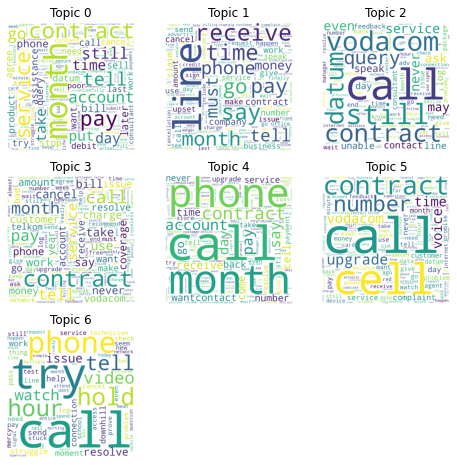

In [56]:
# create a sample dataset for testing
df_train = df_complaints_balance.sample(n=100, random_state=random_seed)

# create the topic modeler and perform the pre-processing steps
topic_modeler = TopicModeling(df_train, random_seed)
topic_modeler.setup(target='review_content_clean', custom_stopwords=None, verbose=True)

# create the model
#model = topic_modeler.create_tuned_model(model='lda', fold=10, verbose=True)
model = topic_modeler.create_model(model='lda', num_topics=7, verbose=False)

#print(topic_modeler.assign_model().head()[['review_content_clean']])
#print(pd.DataFrame([" ".join(item) for item in topic_modeler.text], columns=['topic_text']))
#topic_modeler.assign_model().head()

#topic_modeler.plot_wordcloud(1)
topic_modeler.plot_wordcloud_grid()

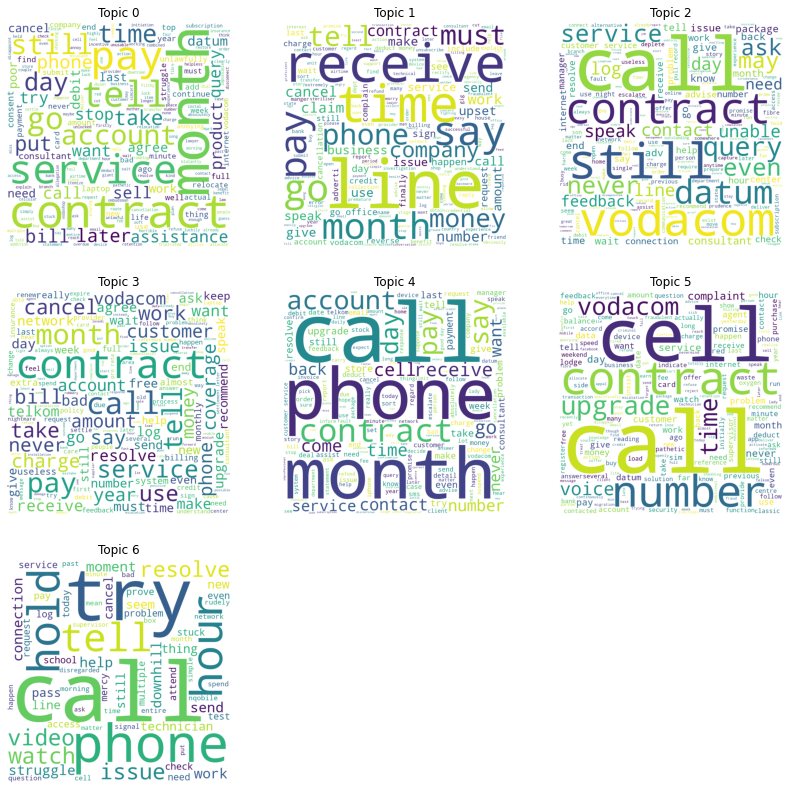

In [57]:
topic_modeler.plot_wordcloud_grid(figsize=(14, 14))

In [41]:
# create a sample dataset for testing
df_train = df_complaints_balance.sample(n=100, random_state=random_seed)

# create the topic modeler and perform the pre-processing steps
topic_modeler = TopicModeling(df_train, random_seed)
topic_modeler.setup(target='review_content_clean', custom_stopwords=None, verbose=False)

# create the model
model = topic_modeler.create_model(model='lda', num_topics=7, verbose=False)

#topic_modeler.extract_topic_coherence_data()
topic_modeler.show_topic_coherence_data()

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


| Topic | Words | Sample 1 | Sample 2 | Sample 3 |
|-------|------|-------|-------|-------|
| Topic 0 | month contract get pay service tell account still go phone | absolutely filthy service, firstly they without consent put (up sell products ) unlawfully on ones account and do not stop a contract that has ended over a year ago and assume you want month to month and when queried simply told no please settle accounts. i took out a laptop contract for R600 as per agreed to find they added top up airtimes etc amounting to close to R1000 then when queried no please pay then we talk. They then combined my cell phone contract which ended 2019 (paid in full) they upon many requests to stop top up incentives as i did not want anything and cancellation of cellular insurance they continue billing me and now soft locked a phone which i have paid in full already told me that they will continue billing me without fail and that the data will remain unusable even though I had not consented any of thi

In [38]:
topic_modeler.show_topic_coherence_data()

In [37]:
md('# Test')

# Test

In [ ]:
topic_data = model.show_topics(formatted=False, num_words=10)
for topic_num, word_data in topic_data:
    word_list = " ".join([word for word, _ in word_data])
    print(word_list)

In [ ]:
topic_modeler.assigned_data.sort_values(by='Perc_Dominant_Topic', ascending=False).head()

In [ ]:
plot_model(model, plot = 'umap')

In [ ]:
plot_model(model, plot='topic_distribution')

In [ ]:
%%capture captured
plot_model(model, plot='topic_distribution')

In [ ]:
for i, o in enumerate(captured.outputs):
    print([t for t, content in o.data.items()])

In [ ]:
import plotly
import json
import kaleido

json_plotly = json.dumps(list(captured.outputs[1].data.items())[0][1])
figure_plotly = plotly.io.from_json(json_plotly)
figure_plotly.show(renderer="png")

In [ ]:
with io.capture_output() as captured:
    plot_model(model, plot='topic_distribution')

json_plotly = json.dumps(list(captured.outputs[1].data.items())[0][1])
figure_plotly = plotly.io.from_json(json_plotly)
figure_plotly.show(renderer="png")

In [ ]:
custom_stopwords = []
session_id = 2480
target_column = 'review_content_clean'
data = telecom_reviews
#data = df_complaints_balance.sample(n=100, random_state=random_seed)

# initialize the setup
nlp = setup(
    data=data, 
    target=target_column, 
    session_id=session_id, 
    #custom_stopwords=custom_stopwords
)

In [ ]:
# create the model
lda = create_model('lda', num_topics = 6, multi_core = True)

In [ ]:
plot_model(lda, plot='wordcloud', topic_num=5)

In [ ]:
#evaluate_model(lda)

In [ ]:
# Intrinsic Evaluation using Coherence Value
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

In [ ]:
?tuned_unsupervised.get_topics

In [ ]:
len(tuned_unsupervised.get_topics())

In [ ]:
?tuned_unsupervised.get_topic_terms

In [ ]:
model.get_topic_terms(1)

In [ ]:
tuned_unsupervised.ge

In [ ]:
tuned_unsupervised.show_topics(formatted=False)

In [ ]:
df_complaints.iplot()